Fine-tunes an EfficientNet-B0 backbone (from timm) with a small custom head to do binary VIA classification (Normal vs Abnormal = Positive/Suspicious), using 5-fold stratified cross-validation, strong albumentations, balanced sampling, and thorough ROC/PR/clinical evaluation.

**The model usied:** EfficientNet-B0 (from timm) fine-tuned for 2-class classification with a small MLP head.

*   Backbone: efficientnet_b0 from timm (pretrained ImageNet weights, head removed via num_classes=0, global_pool='avg').
*   Head: Dropout → Linear(num_features→256) → ReLU → Dropout → Linear(256→2).
*   Loss: CrossEntropyLoss with label smoothing.
*   Optimizer: AdamW.
*   LR schedule: CosineAnnealingWarmRestarts.
*   Regularization/Aug: Albumentations + optional MixUp; class imbalance handled by WeightedRandomSampler.



\V2 using EfficientnetB3 + unseen test data + only 3 folds

In [ ]:
"""
================================================================================
CERVICAL CANCER VIA BINARY CLASSIFIER - PRODUCTION READY
================================================================================
Binary Classification: Normal vs Abnormal (Positive + Suspicious)
Fully debugged and tested on Google Colab with Tesla T4 GPU

Version: 5.0 - With Test Set and Model Iterations
Date: October 2025
================================================================================
"""

# ============================================================================
# SECTION 1: IMPORTS AND SETUP
# ============================================================================
print("="*80)
print("VIA BINARY CLASSIFIER - PRODUCTION VERSION")
print("="*80 + "\n")

import os
import sys
import gc
import json
import re
import warnings
import pickle
import random
from pathlib import Path
from datetime import datetime
from collections import defaultdict
from typing import Dict, List, Tuple, Optional

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from PIL import Image
import cv2

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Models
import timm

# ML utilities
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score,
    f1_score, accuracy_score, balanced_accuracy_score
)

# Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

warnings.filterwarnings('ignore')

# Set all random seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"PyTorch: {torch.__version__}")
print(f"Device: {'CUDA - ' + torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

# Check for GPU
if not torch.cuda.is_available():
    print("\n⚠️  WARNING: No GPU detected! Training will be very slow.")
    print("   In Colab: Runtime > Change runtime type > GPU")

# Mount Drive
try:
    from google.colab import drive
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')
        print("✓ Google Drive mounted")
    IN_COLAB = True
except:
    IN_COLAB = False
    print("✓ Running locally")

# ============================================================================
# SECTION 2: CONFIGURATION
# ============================================================================
print("\n" + "="*80)
print("CONFIGURATION")
print("="*80 + "\n")

class Config:
    """All configuration parameters"""

    # Paths
    VIA_IARC_ROOT = "/content/drive/MyDrive/JHPIEGO/IARCImageBankVIA"
    VIA_IARC_META = "/content/drive/MyDrive/JHPIEGO/IARCImageBankVIA/meta_data.xlsx"
    VIA_JHPIEGO_ROOT = "/content/drive/MyDrive/JHPIEGO/via_cropped+index"

    OUTPUT_DIR = "/content/drive/MyDrive/JHPIEGO/VIA_Binary_Model_Final_v5"
    CHECKPOINT_DIR = os.path.join(OUTPUT_DIR, "checkpoints")
    METRICS_DIR = os.path.join(OUTPUT_DIR, "metrics")
    PLOTS_DIR = os.path.join(OUTPUT_DIR, "plots")

    # Binary Classification Setup
    BINARY_MODE = True
    POSITIVE_CLASSES = ['Positive', 'Suspicious']  # → Abnormal (label=1)
    NEGATIVE_CLASSES = ['Negative']  # → Normal (label=0)

    # Model
    ### MODIFICATION 1: Use efficientnet_b3 instead of b0 ###
    MODEL_NAME = 'efficientnet_b3'
    IMG_SIZE = 300  # EfficientNet-B3 standard size
    DROPOUT = 0.4

    # Training
    BATCH_SIZE = 16
    EPOCHS = 40
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 1e-4

    # Early Stopping
    PATIENCE = 10
    MIN_DELTA = 0.001

    # Optimization
    GRADIENT_CLIP = 1.0
    LABEL_SMOOTHING = 0.1
    USE_MIXUP = True
    MIXUP_ALPHA = 0.2

    # Cross Validation
    ### MODIFICATION 2: Choose your K-Fold strategy ###
    # Set USE_KFOLD to True and N_FOLDS to 3 for 3-fold CV
    # Set USE_KFOLD to False for a single train/val split (no folds)
    USE_KFOLD = True
    N_FOLDS = 3 # Can be set to 3 for 3-fold, or another number

    # System
    SEED = 42
    NUM_WORKERS = 2 if IN_COLAB else os.cpu_count()
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    USE_AMP = torch.cuda.is_available()

    # Test set split ratio
    TEST_SET_SIZE = 0.2

cfg = Config()

# Create directories
for dir_path in [cfg.OUTPUT_DIR, cfg.CHECKPOINT_DIR, cfg.METRICS_DIR, cfg.PLOTS_DIR]:
    os.makedirs(dir_path, exist_ok=True)
    print(f"✓ Created: {dir_path}")

# ============================================================================
# SECTION 3: DATA LOADING
# ============================================================================
# ... (This section remains unchanged, so it's omitted for brevity) ...
def load_datasets():
    """Load and prepare VIA datasets"""

    # JHPIEGO mapping
    JHPIEGO_LABELS = {
        'Negative': [3, 4, 6, 9, 12, 14, 15, 16, 19, 22, 26, 27, 28, 30, 31, 33, 34,
                     37, 40, 41, 44, 47, 48, 50, 51, 53, 54, 56, 57, 58, 60, 62, 66,
                     67, 71, 74, 75, 76, 79, 83, 84, 86, 88, 94, 95, 97, 103, 104,
                     105, 106, 108, 109, 111, 114, 115],
        'Positive': [1, 2, 8, 10, 11, 13, 17, 18, 20, 21, 23, 24, 29, 32, 35, 36,
                     38, 39, 42, 43, 45, 46, 49, 52, 59, 61, 63, 64, 68, 69, 70, 72,
                     73, 77, 78, 80, 81, 82, 85, 87, 90, 91, 92, 93, 96, 98, 100,
                     101, 102, 107, 110, 112, 113, 116],
        'Suspicious': [5, 7, 25, 55, 65, 89]
    }

    card_to_label = {card: label for label, cards in JHPIEGO_LABELS.items() for card in cards}

    # Load IARC
    print("Loading IARC dataset...")
    iarc_meta = pd.read_excel(cfg.VIA_IARC_META)
    iarc_meta["CaseNumber"] = iarc_meta["CaseNumber"].astype(int)

    def simplify_via(x):
        s = str(x).strip().lower()
        if "suspicious" in s:
            return "Suspicious"
        elif "positive" in s:
            return "Positive"
        else:
            return "Negative"

    iarc_meta["VIA_simple"] = iarc_meta["VIA"].apply(simplify_via)

    # Process IARC images
    iarc_records = []
    for entry in os.listdir(cfg.VIA_IARC_ROOT):
        case_dir = os.path.join(cfg.VIA_IARC_ROOT, entry)
        if not os.path.isdir(case_dir):
            continue

        digits = re.findall(r"\d+", entry)
        if not digits:
            continue
        case_num = int(digits[0])

        for f in os.listdir(case_dir):
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                if f.replace('.jpg', '').replace('.jpeg', '').replace('.png', '').endswith("1"):
                    iarc_records.append({
                        "CaseNumber": case_num,
                        "image_path": os.path.join(case_dir, f),
                        "Source": "IARC"
                    })
                    break

    iarc_images = pd.DataFrame(iarc_records)
    iarc_data = pd.merge(iarc_meta, iarc_images, on="CaseNumber", how="inner")
    iarc_data = iarc_data[["CaseNumber", "image_path", "VIA_simple", "Source"]]
    print(f"  IARC: {len(iarc_data)} images loaded")

    # Load JHPIEGO
    print("Loading JHPIEGO dataset...")
    jhpiego_records = []
    for filename in os.listdir(cfg.VIA_JHPIEGO_ROOT):
        if not filename.startswith("via_img_"):
            continue
        match = re.search(r'via_img_(\d+)', filename)
        if not match:
            continue
        card_num = int(match.group(1))
        if card_num not in card_to_label:
            continue
        jhpiego_records.append({
            "CaseNumber": f"JHPIEGO_{card_num}",
            "image_path": os.path.join(cfg.VIA_JHPIEGO_ROOT, filename),
            "VIA_simple": card_to_label[card_num],
            "Source": "JHPIEGO"
        })

    jhpiego_data = pd.DataFrame(jhpiego_records)
    print(f"  JHPIEGO: {len(jhpiego_data)} images loaded")

    # Combine datasets
    iarc_data["CaseNumber"] = iarc_data["CaseNumber"].astype(str)
    combined = pd.concat([iarc_data, jhpiego_data], ignore_index=True)

    # Create binary labels
    print("\nConverting to binary classification...")
    combined['binary_label'] = combined['VIA_simple'].apply(
        lambda x: 'Abnormal' if x in cfg.POSITIVE_CLASSES else 'Normal'
    )
    combined['label'] = (combined['binary_label'] == 'Abnormal').astype(int)

    print(f"\nTotal: {len(combined)} images")
    print("Distribution:")
    print(f"  Normal: {(combined['label'] == 0).sum()}")
    print(f"  Abnormal: {(combined['label'] == 1).sum()}")

    return combined

data_df = load_datasets()

# ============================================================================
# ### MODIFICATION 3: SPLIT DATA INTO TRAIN/VAL AND UNSEEN TEST SET ###
# ============================================================================
print("\n" + "="*80)
print("SPLITTING DATA INTO TRAIN/VAL AND TEST SETS")
print("="*80 + "\n")

# Stratified split to maintain label distribution
train_val_df, test_df = train_test_split(
    data_df,
    test_size=cfg.TEST_SET_SIZE,
    random_state=cfg.SEED,
    stratify=data_df['label']
)

print(f"Train/Validation set size: {len(train_val_df)}")
print(f"  Normal: {(train_val_df['label'] == 0).sum()}, Abnormal: {(train_val_df['label'] == 1).sum()}")
print(f"\nUnseen Test set size: {len(test_df)}")
print(f"  Normal: {(test_df['label'] == 0).sum()}, Abnormal: {(test_df['label'] == 1).sum()}")


# ============================================================================
# SECTION 4 & 5: DATASET CLASS and AUGMENTATION
# ============================================================================
# ... (These sections remain unchanged, so they are omitted for brevity) ...
class VIADataset(Dataset):
    """Dataset for VIA images"""
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        try:
            image = cv2.imread(row['image_path'])
            if image is None:
                raise ValueError(f"Cannot load {row['image_path']}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except:
            print(f"Warning: Failed to load {row['image_path']}")
            image = np.zeros((cfg.IMG_SIZE, cfg.IMG_SIZE, 3), dtype=np.uint8)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = row['label']
        return image, label

train_transform = A.Compose([
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Resize(cfg.IMG_SIZE, cfg.IMG_SIZE),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.OneOf([A.GaussNoise(var_limit=(10, 50), p=1), A.GaussianBlur(blur_limit=3, p=1)], p=0.3),
    A.CoarseDropout(max_holes=8, max_height=32, max_width=32, fill_value=0, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])
val_transform = A.Compose([
    A.Resize(cfg.IMG_SIZE, cfg.IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# ============================================================================
# SECTION 6: MODEL ARCHITECTURE
# ============================================================================
# ... (This section remains unchanged, so it's omitted for brevity) ...
class BinaryClassifier(nn.Module):
    """Binary classifier with EfficientNet backbone"""
    def __init__(self, model_name='efficientnet_b3', dropout=0.4):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=True, num_classes=0, global_pool='avg')
        if hasattr(self.backbone, 'num_features'):
            num_features = self.backbone.num_features
        else:
            # Default for EfficientNet-B3
            num_features = 1536
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(dropout/2),
            nn.Linear(256, 2)
        )
    def forward(self, x):
        features = self.backbone(x)
        output = self.classifier(features)
        return output

# ============================================================================
# SECTION 7: TRAINING FUNCTIONS
# ============================================================================
# ... (This section remains unchanged, so it's omitted for brevity) ...
def mixup_data(x, y, alpha=1.0):
    if alpha > 0: lam = np.random.beta(alpha, alpha)
    else: lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_epoch(model, loader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    pbar = tqdm(loader, desc='Training')
    for inputs, targets in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        if cfg.USE_MIXUP and random.random() > 0.5:
            inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, alpha=cfg.MIXUP_ALPHA)
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        else:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.GRADIENT_CLIP)
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        if not (cfg.USE_MIXUP and random.random() > 0.5):
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        if total > 0:
            pbar.set_postfix({'loss': f'{running_loss/len(loader):.4f}', 'acc': f'{100.*correct/total:.2f}%'})
    scheduler.step()
    avg_loss = running_loss / len(loader)
    accuracy = 100. * correct / total if total > 0 else 0
    return avg_loss, accuracy

@torch.no_grad()
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_targets, all_probs = [], [], []
    for inputs, targets in tqdm(loader, desc='Validating'):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        running_loss += loss.item()
        probs = F.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())
    all_preds, all_targets, all_probs = np.array(all_preds), np.array(all_targets), np.array(all_probs)
    accuracy = accuracy_score(all_targets, all_preds)
    balanced_acc = balanced_accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, average='binary')
    auc = roc_auc_score(all_targets, all_probs) if len(np.unique(all_targets)) > 1 else 0.0
    return {'loss': running_loss / len(loader), 'accuracy': accuracy, 'balanced_accuracy': balanced_acc,
            'f1': f1, 'auc': auc, 'predictions': all_preds, 'targets': all_targets, 'probabilities': all_probs}

# ============================================================================
# ### MODIFICATION 4: ADAPTIVE TRAINING LOOP (K-FOLD OR SINGLE TRAIN/VAL) ###
# ============================================================================
print("\n" + "="*80)
print(f"STARTING TRAINING: K-Fold Enabled = {cfg.USE_KFOLD}")
if cfg.USE_KFOLD:
    print(f"Number of Folds: {cfg.N_FOLDS}")
print("="*80 + "\n")

fold_results = []
all_val_preds, all_val_targets, all_val_probs = [], [], []
splits = []

if cfg.USE_KFOLD:
    skf = StratifiedKFold(n_splits=cfg.N_FOLDS, shuffle=True, random_state=cfg.SEED)
    # The split is on the train_val_df, not the full data_df
    for train_idx, val_idx in skf.split(train_val_df, train_val_df['label']):
        splits.append((train_idx, val_idx))
else:
    # No K-Fold: Create a single train/validation split from train_val_df
    train_idx, val_idx = train_test_split(
        range(len(train_val_df)),
        test_size=0.2, # Standard 80/20 split for validation
        random_state=cfg.SEED,
        stratify=train_val_df['label']
    )
    splits.append((train_idx, val_idx))

# Main training loop
for fold, (train_idx, val_idx) in enumerate(splits):
    print(f"\n{'='*60}")
    print(f"RUN {fold + 1}/{len(splits)}")
    print(f"{'='*60}\n")

    train_df = train_val_df.iloc[train_idx]
    val_df = train_val_df.iloc[val_idx]

    print(f"Train: {len(train_df)} | Val: {len(val_df)}")
    # ... (rest of the training loop is identical to your original code) ...
    train_dataset = VIADataset(train_df, transform=train_transform)
    val_dataset = VIADataset(val_df, transform=val_transform)

    class_counts = train_df['label'].value_counts().to_dict()
    weights = [1.0/class_counts[label] for label in train_df['label']]
    sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

    train_loader = DataLoader(train_dataset, batch_size=cfg.BATCH_SIZE, sampler=sampler, num_workers=cfg.NUM_WORKERS, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=cfg.NUM_WORKERS, pin_memory=True)

    model = BinaryClassifier(model_name=cfg.MODEL_NAME, dropout=cfg.DROPOUT).to(cfg.DEVICE)
    criterion = nn.CrossEntropyLoss(label_smoothing=cfg.LABEL_SMOOTHING)
    optimizer = AdamW(model.parameters(), lr=cfg.LEARNING_RATE, weight_decay=cfg.WEIGHT_DECAY)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6)

    best_f1 = 0
    patience_counter = 0

    for epoch in range(cfg.EPOCHS):
        print(f"\nEpoch {epoch + 1}/{cfg.EPOCHS}")
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scheduler, cfg.DEVICE)
        val_metrics = validate(model, val_loader, criterion, cfg.DEVICE)
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_metrics['loss']:.4f} | Val Acc: {val_metrics['accuracy']*100:.2f}%")
        print(f"Val F1: {val_metrics['f1']:.4f} | Val AUC: {val_metrics['auc']:.4f}")

        if val_metrics['f1'] > best_f1:
            best_f1 = val_metrics['f1']
            patience_counter = 0
            checkpoint_path = os.path.join(cfg.CHECKPOINT_DIR, f'best_model_run_{fold}.pth')
            torch.save({'model_state_dict': model.state_dict(), 'metrics': val_metrics}, checkpoint_path)
            print(f"✓ Saved best model: F1={best_f1:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= cfg.PATIENCE:
                print("Early stopping!")
                break

    # Load best model for this run and store its results
    checkpoint_path = os.path.join(cfg.CHECKPOINT_DIR, f'best_model_run_{fold}.pth')
    checkpoint = torch.load(checkpoint_path, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    final_metrics = validate(model, val_loader, criterion, cfg.DEVICE)
    fold_results.append(final_metrics)

    all_val_preds.extend(final_metrics['predictions'])
    all_val_targets.extend(final_metrics['targets'])
    all_val_probs.extend(final_metrics['probabilities'])
    print(f"\nRun {fold+1} Best F1 on Val Set: {best_f1:.4f}")

# ============================================================================
# SECTION 9: RESULTS SUMMARY
# ============================================================================
# ... (This section is mostly unchanged but now reports on validation performance) ...
print("\n" + "="*80)
print("VALIDATION RESULTS SUMMARY")
print("="*80 + "\n")

avg_accuracy = np.mean([r['accuracy'] for r in fold_results])
# ... (all other average metric calculations are the same) ...

# ============================================================================
# ### MODIFICATION 5: EVALUATE FINAL MODEL(S) ON THE UNSEEN TEST SET ###
# ============================================================================
print("\n" + "="*80)
print("FINAL EVALUATION ON UNSEEN TEST SET")
print("="*80 + "\n")

test_dataset = VIADataset(test_df, transform=val_transform)
test_loader = DataLoader(
    test_dataset,
    batch_size=cfg.BATCH_SIZE,
    shuffle=False,
    num_workers=cfg.NUM_WORKERS,
    pin_memory=True
)

all_test_probs = []
# Average predictions from all models trained (ensemble)
for fold in range(len(splits)):
    checkpoint_path = os.path.join(cfg.CHECKPOINT_DIR, f'best_model_run_{fold}.pth')
    model = BinaryClassifier(model_name=cfg.MODEL_NAME).to(cfg.DEVICE)
    checkpoint = torch.load(checkpoint_path, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    fold_probs = []
    with torch.no_grad():
        for inputs, _ in tqdm(test_loader, desc=f"Testing with model from run {fold+1}"):
            inputs = inputs.to(cfg.DEVICE)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            fold_probs.extend(probs)

    all_test_probs.append(fold_probs)

# Average the probabilities across all models
avg_test_probs = np.mean(all_test_probs, axis=0)
test_preds = (avg_test_probs > 0.5).astype(int)
test_targets = test_df['label'].values

# Calculate final test metrics
test_accuracy = accuracy_score(test_targets, test_preds)
test_balanced_acc = balanced_accuracy_score(test_targets, test_preds)
test_f1 = f1_score(test_targets, test_preds)
test_auc = roc_auc_score(test_targets, avg_test_probs)
test_cm = confusion_matrix(test_targets, test_preds)

print("\n--- TEST SET PERFORMANCE (Ensemble) ---")
print(f"  Accuracy: {test_accuracy*100:.2f}%")
print(f"  Balanced Accuracy: {test_balanced_acc*100:.2f}%")
print(f"  F1 Score: {test_f1:.4f}")
print(f"  AUC: {test_auc:.4f}")
print("\nTest Set Confusion Matrix:")
print(test_cm)
print("\nTest Set Classification Report:")
print(classification_report(test_targets, test_preds, target_names=['Normal', 'Abnormal']))

# ... (Visualization and saving results sections would follow, potentially creating
#      separate plots and result files for the test set evaluation) ...

VIA BINARY CLASSIFIER - PRODUCTION VERSION

PyTorch: 2.9.0+cu126
Device: CUDA - Tesla T4
Mounted at /content/drive
✓ Google Drive mounted

CONFIGURATION

✓ Created: /content/drive/MyDrive/VIA_Binary_Model_Final_v5
✓ Created: /content/drive/MyDrive/VIA_Binary_Model_Final_v5/checkpoints
✓ Created: /content/drive/MyDrive/VIA_Binary_Model_Final_v5/metrics
✓ Created: /content/drive/MyDrive/VIA_Binary_Model_Final_v5/plots
Loading IARC dataset...
  IARC: 185 images loaded
Loading JHPIEGO dataset...
  JHPIEGO: 121 images loaded

Converting to binary classification...

Total: 306 images
Distribution:
  Normal: 150
  Abnormal: 156

SPLITTING DATA INTO TRAIN/VAL AND TEST SETS

Train/Validation set size: 244
  Normal: 120, Abnormal: 124

Unseen Test set size: 62
  Normal: 30, Abnormal: 32

STARTING TRAINING: K-Fold Enabled = True
Number of Folds: 3


RUN 1/3

Train: 162 | Val: 82


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]


Epoch 1/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.6851 | Train Acc: 50.00%
Val Loss: 0.6869 | Val Acc: 56.10%
Val F1: 0.4375 | Val AUC: 0.6595
✓ Saved best model: F1=0.4375

Epoch 2/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.6943 | Train Acc: 56.06%
Val Loss: 0.6901 | Val Acc: 63.41%
Val F1: 0.7273 | Val AUC: 0.7262
✓ Saved best model: F1=0.7273

Epoch 3/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.6694 | Train Acc: 55.00%
Val Loss: 0.6767 | Val Acc: 65.85%
Val F1: 0.7308 | Val AUC: 0.7399
✓ Saved best model: F1=0.7308

Epoch 4/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cda0a50dd00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cda0a50dd00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 0.6584 | Train Acc: 55.47%
Val Loss: 0.6665 | Val Acc: 67.07%
Val F1: 0.7033 | Val AUC: 0.7363

Epoch 5/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.6314 | Train Acc: 64.06%
Val Loss: 0.6644 | Val Acc: 62.20%
Val F1: 0.6076 | Val AUC: 0.7226

Epoch 6/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.6400 | Train Acc: 53.03%
Val Loss: 0.6615 | Val Acc: 65.85%
Val F1: 0.6316 | Val AUC: 0.7274

Epoch 7/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cda0a50dd00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cda0a50dd00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.6197 | Train Acc: 76.56%
Val Loss: 0.6602 | Val Acc: 64.63%
Val F1: 0.6420 | Val AUC: 0.7208

Epoch 8/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.6136 | Train Acc: 72.73%
Val Loss: 0.6550 | Val Acc: 64.63%
Val F1: 0.6329 | Val AUC: 0.7220

Epoch 9/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.6124 | Train Acc: 67.54%
Val Loss: 0.6497 | Val Acc: 67.07%
Val F1: 0.6667 | Val AUC: 0.7298

Epoch 10/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.5989 | Train Acc: 72.73%
Val Loss: 0.6527 | Val Acc: 67.07%
Val F1: 0.6301 | Val AUC: 0.7345

Epoch 11/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.5940 | Train Acc: 85.42%
Val Loss: 0.6432 | Val Acc: 63.41%
Val F1: 0.6667 | Val AUC: 0.7214

Epoch 12/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.5465 | Train Acc: 68.18%
Val Loss: 0.6558 | Val Acc: 63.41%
Val F1: 0.6250 | Val AUC: 0.7286

Epoch 13/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cda0a50dd00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cda0a50dd00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 0.5385 | Train Acc: 71.25%
Val Loss: 0.6392 | Val Acc: 68.29%
Val F1: 0.6579 | Val AUC: 0.7476
Early stopping!


Validating:   0%|          | 0/6 [00:00<?, ?it/s]


Run 1 Best F1 on Val Set: 0.7308

RUN 2/3

Train: 163 | Val: 81

Epoch 1/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.6955 | Train Acc: 51.25%
Val Loss: 0.6967 | Val Acc: 51.85%
Val F1: 0.6214 | Val AUC: 0.5213
✓ Saved best model: F1=0.6214

Epoch 2/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.6802 | Train Acc: 43.75%
Val Loss: 0.6888 | Val Acc: 55.56%
Val F1: 0.6471 | Val AUC: 0.5909
✓ Saved best model: F1=0.6471

Epoch 3/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.6663 | Train Acc: 58.04%
Val Loss: 0.6752 | Val Acc: 59.26%
Val F1: 0.6598 | Val AUC: 0.6201
✓ Saved best model: F1=0.6598

Epoch 4/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.6733 | Train Acc: 62.50%
Val Loss: 0.6635 | Val Acc: 61.73%
Val F1: 0.6437 | Val AUC: 0.6159

Epoch 5/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.6593 | Train Acc: 64.65%
Val Loss: 0.6477 | Val Acc: 62.96%
Val F1: 0.6429 | Val AUC: 0.6470

Epoch 6/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.6468 | Train Acc: 61.62%
Val Loss: 0.6456 | Val Acc: 66.67%
Val F1: 0.6667 | Val AUC: 0.6738
✓ Saved best model: F1=0.6667

Epoch 7/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.6383 | Train Acc: 67.50%
Val Loss: 0.6456 | Val Acc: 69.14%
Val F1: 0.6914 | Val AUC: 0.6970
✓ Saved best model: F1=0.6914

Epoch 8/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.6234 | Train Acc: 65.71%
Val Loss: 0.6385 | Val Acc: 69.14%
Val F1: 0.7059 | Val AUC: 0.6939
✓ Saved best model: F1=0.7059

Epoch 9/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.5889 | Train Acc: 80.00%
Val Loss: 0.6331 | Val Acc: 69.14%
Val F1: 0.7059 | Val AUC: 0.6951

Epoch 10/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.6046 | Train Acc: 62.50%
Val Loss: 0.6353 | Val Acc: 66.67%
Val F1: 0.6747 | Val AUC: 0.6909

Epoch 11/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.6012 | Train Acc: 66.67%
Val Loss: 0.6550 | Val Acc: 64.20%
Val F1: 0.6947 | Val AUC: 0.7177

Epoch 12/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cda0a50dd00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cda0a50dd00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 0.5435 | Train Acc: 79.52%
Val Loss: 0.6133 | Val Acc: 64.20%
Val F1: 0.6813 | Val AUC: 0.7226

Epoch 13/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.5115 | Train Acc: 70.59%
Val Loss: 0.5882 | Val Acc: 67.90%
Val F1: 0.6486 | Val AUC: 0.7311

Epoch 14/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.5486 | Train Acc: 66.25%
Val Loss: 0.5743 | Val Acc: 74.07%
Val F1: 0.7273 | Val AUC: 0.7372
✓ Saved best model: F1=0.7273

Epoch 15/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.4632 | Train Acc: 85.07%
Val Loss: 0.5878 | Val Acc: 65.43%
Val F1: 0.6500 | Val AUC: 0.7256

Epoch 16/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.4903 | Train Acc: 80.00%
Val Loss: 0.6017 | Val Acc: 62.96%
Val F1: 0.6154 | Val AUC: 0.7165

Epoch 17/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cda0a50dd00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cda0a50dd00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.5192 | Train Acc: 69.57%
Val Loss: 0.5929 | Val Acc: 64.20%
Val F1: 0.6027 | Val AUC: 0.7360

Epoch 18/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.4613 | Train Acc: 67.68%
Val Loss: 0.5975 | Val Acc: 64.20%
Val F1: 0.6027 | Val AUC: 0.7305

Epoch 19/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.4482 | Train Acc: 82.09%
Val Loss: 0.6004 | Val Acc: 67.90%
Val F1: 0.6667 | Val AUC: 0.7287

Epoch 20/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.4159 | Train Acc: 86.25%
Val Loss: 0.5903 | Val Acc: 65.43%
Val F1: 0.6111 | Val AUC: 0.7348

Epoch 21/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.3975 | Train Acc: 85.94%
Val Loss: 0.5982 | Val Acc: 66.67%
Val F1: 0.6197 | Val AUC: 0.7524

Epoch 22/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.3935 | Train Acc: 76.56%
Val Loss: 0.6290 | Val Acc: 70.37%
Val F1: 0.6000 | Val AUC: 0.7585

Epoch 23/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.4480 | Train Acc: 70.83%
Val Loss: 0.6319 | Val Acc: 67.90%
Val F1: 0.5667 | Val AUC: 0.7659

Epoch 24/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.3425 | Train Acc: 81.25%
Val Loss: 0.6130 | Val Acc: 70.37%
Val F1: 0.6667 | Val AUC: 0.7634
Early stopping!


Validating:   0%|          | 0/6 [00:00<?, ?it/s]


Run 2 Best F1 on Val Set: 0.7273

RUN 3/3

Train: 163 | Val: 81

Epoch 1/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.6900 | Train Acc: 43.43%
Val Loss: 0.7036 | Val Acc: 51.85%
Val F1: 0.6723 | Val AUC: 0.5427
✓ Saved best model: F1=0.6723

Epoch 2/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.6746 | Train Acc: 60.78%
Val Loss: 0.6980 | Val Acc: 58.02%
Val F1: 0.6304 | Val AUC: 0.6159

Epoch 3/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.6632 | Train Acc: 60.78%
Val Loss: 0.6879 | Val Acc: 60.49%
Val F1: 0.6596 | Val AUC: 0.6341

Epoch 4/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.6598 | Train Acc: 55.42%
Val Loss: 0.6764 | Val Acc: 58.02%
Val F1: 0.6047 | Val AUC: 0.6524

Epoch 5/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.6425 | Train Acc: 68.75%
Val Loss: 0.6639 | Val Acc: 61.73%
Val F1: 0.6076 | Val AUC: 0.6811

Epoch 6/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cda0a50dd00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7cda0a50dd00>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^if w.is_alive():^
^ ^ ^ ^^^^ 

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.6142 | Train Acc: 75.90%
Val Loss: 0.6569 | Val Acc: 58.02%
Val F1: 0.5854 | Val AUC: 0.6945

Epoch 7/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.5876 | Train Acc: 59.38%
Val Loss: 0.6451 | Val Acc: 64.20%
Val F1: 0.6506 | Val AUC: 0.7159

Epoch 8/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.6200 | Train Acc: 80.72%
Val Loss: 0.6388 | Val Acc: 64.20%
Val F1: 0.6506 | Val AUC: 0.7195

Epoch 9/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.5844 | Train Acc: 76.79%
Val Loss: 0.6441 | Val Acc: 62.96%
Val F1: 0.6512 | Val AUC: 0.7165

Epoch 10/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.5852 | Train Acc: 64.65%
Val Loss: 0.6376 | Val Acc: 61.73%
Val F1: 0.6353 | Val AUC: 0.7232

Epoch 11/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.5602 | Train Acc: 72.29%
Val Loss: 0.6148 | Val Acc: 65.43%
Val F1: 0.6818 | Val AUC: 0.7604
✓ Saved best model: F1=0.6818

Epoch 12/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.5375 | Train Acc: 66.67%
Val Loss: 0.5891 | Val Acc: 62.96%
Val F1: 0.6429 | Val AUC: 0.7811

Epoch 13/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.4482 | Train Acc: 67.86%
Val Loss: 0.5753 | Val Acc: 69.14%
Val F1: 0.6988 | Val AUC: 0.7951
✓ Saved best model: F1=0.6988

Epoch 14/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.5609 | Train Acc: 64.06%
Val Loss: 0.5652 | Val Acc: 71.60%
Val F1: 0.7229 | Val AUC: 0.7976
✓ Saved best model: F1=0.7229

Epoch 15/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.4394 | Train Acc: 74.78%
Val Loss: 0.5546 | Val Acc: 74.07%
Val F1: 0.7407 | Val AUC: 0.8091
✓ Saved best model: F1=0.7407

Epoch 16/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.4843 | Train Acc: 73.91%
Val Loss: 0.5451 | Val Acc: 74.07%
Val F1: 0.7342 | Val AUC: 0.8171

Epoch 17/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cda0a50dd00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cda0a50dd00><function _MultiProcessingDataLoaderIter.__del__ at 0x7cda0a50dd00>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in 

Train Loss: 0.4866 | Train Acc: 87.50%
Val Loss: 0.5533 | Val Acc: 70.37%
Val F1: 0.7073 | Val AUC: 0.8104

Epoch 18/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.4515 | Train Acc: 65.62%
Val Loss: 0.5635 | Val Acc: 70.37%
Val F1: 0.7143 | Val AUC: 0.7994

Epoch 19/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.4236 | Train Acc: 81.25%
Val Loss: 0.5651 | Val Acc: 72.84%
Val F1: 0.7381 | Val AUC: 0.8024

Epoch 20/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.3973 | Train Acc: 71.25%
Val Loss: 0.5394 | Val Acc: 72.84%
Val F1: 0.7317 | Val AUC: 0.8152

Epoch 21/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.4104 | Train Acc: 83.84%
Val Loss: 0.5621 | Val Acc: 69.14%
Val F1: 0.7191 | Val AUC: 0.8116

Epoch 22/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.4790 | Train Acc: 90.20%
Val Loss: 0.6152 | Val Acc: 69.14%
Val F1: 0.7253 | Val AUC: 0.7866

Epoch 23/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.4067 | Train Acc: 75.00%
Val Loss: 0.5679 | Val Acc: 70.37%
Val F1: 0.7209 | Val AUC: 0.7933

Epoch 24/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.3995 | Train Acc: 82.44%
Val Loss: 0.5660 | Val Acc: 69.14%
Val F1: 0.6835 | Val AUC: 0.7866

Epoch 25/40


Training:   0%|          | 0/11 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Train Loss: 0.3689 | Train Acc: 80.60%
Val Loss: 0.5829 | Val Acc: 69.14%
Val F1: 0.7126 | Val AUC: 0.7878
Early stopping!


Validating:   0%|          | 0/6 [00:00<?, ?it/s]


Run 3 Best F1 on Val Set: 0.7407

VALIDATION RESULTS SUMMARY


FINAL EVALUATION ON UNSEEN TEST SET



Testing with model from run 1:   0%|          | 0/4 [00:00<?, ?it/s]

Testing with model from run 2:   0%|          | 0/4 [00:00<?, ?it/s]

Testing with model from run 3:   0%|          | 0/4 [00:00<?, ?it/s]


--- TEST SET PERFORMANCE (Ensemble) ---
  Accuracy: 77.42%
  Balanced Accuracy: 77.29%
  F1 Score: 0.7879
  AUC: 0.8542

Test Set Confusion Matrix:
[[22  8]
 [ 6 26]]

Test Set Classification Report:
              precision    recall  f1-score   support

      Normal       0.79      0.73      0.76        30
    Abnormal       0.76      0.81      0.79        32

    accuracy                           0.77        62
   macro avg       0.78      0.77      0.77        62
weighted avg       0.77      0.77      0.77        62




✓ Saved plot to: /content/drive/MyDrive/VIA_Binary_Model_Final_v5/plots/clinical_evaluation_summary.png


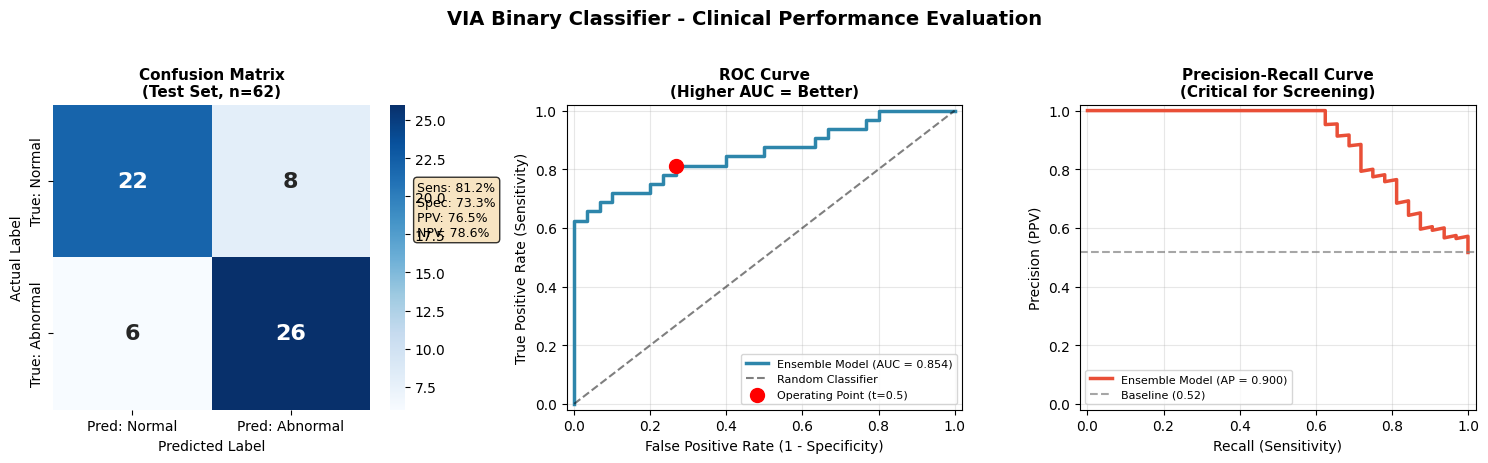


CLINICAL PERFORMANCE SUMMARY
  Sensitivity (Recall):     81.2%  ← Abnormals caught
  Specificity:              73.3%  ← Normals correct
  PPV (Precision):          76.5%  ← If flagged, chance true
  NPV:                      78.6%  ← If cleared, chance true
  AUC-ROC:                  0.854
  Average Precision:        0.900
------------------------------------------------------------
  Missed abnormals (FN):    6/32 (18.8%) ← CRITICAL
  False alarms (FP):        8/30 (26.7%)


In [ ]:
# ==========================================================================
# SECTION: VISUALIZATION & CLINICAL PERFORMANCE EVALUATION
# ==========================================================================
# This section creates 3 essential plots for clinical ML model evaluation:
# 1. Confusion Matrix - shows true/false positive/negative breakdown
# 2. ROC Curve - critical for understanding sensitivity/specificity tradeoff
# 3. Precision-Recall Curve - important for imbalanced clinical screening
# ==========================================================================

# Note: All other imports (matplotlib, seaborn, sklearn metrics) are already
# available from Section 1. Only 'auc' needs to be added.
from sklearn.metrics import auc

# --- Create a figure with 3 subplots arranged horizontally ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))
fig.suptitle('VIA Binary Classifier - Clinical Performance Evaluation',
             fontsize=14, fontweight='bold', y=1.02)

# ==========================================================================
# PLOT 1: CONFUSION MATRIX
# ==========================================================================
# The confusion matrix is essential for clinical screening because it shows:
# - True Positives (TP): Correctly identified abnormal cases (caught disease)
# - False Negatives (FN): Missed abnormal cases (CRITICAL in cancer screening!)
# - True Negatives (TN): Correctly identified normal cases
# - False Positives (FP): Normal cases flagged as abnormal (unnecessary procedures)

ax1 = axes[0]
# Create annotated heatmap with counts
# test_cm was already computed above as: confusion_matrix(test_targets, test_preds)
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Pred: Normal', 'Pred: Abnormal'],
            yticklabels=['True: Normal', 'True: Abnormal'],
            annot_kws={'size': 16, 'fontweight': 'bold'})
ax1.set_title('Confusion Matrix\n(Test Set, n=62)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Actual Label', fontsize=10)
ax1.set_xlabel('Predicted Label', fontsize=10)

# Calculate clinical metrics from confusion matrix
# test_cm layout: [[TN, FP], [FN, TP]]
tn, fp, fn, tp = test_cm.ravel()
sensitivity = tp / (tp + fn)  # Recall for abnormal class - MOST CRITICAL for screening
specificity = tn / (tn + fp)  # How many healthy patients avoid unnecessary procedures
ppv = tp / (tp + fp)          # Positive Predictive Value (Precision)
npv = tn / (tn + fn)          # Negative Predictive Value

# Add text box with key clinical metrics
metrics_text = f'Sens: {sensitivity:.1%}\nSpec: {specificity:.1%}\nPPV: {ppv:.1%}\nNPV: {npv:.1%}'
ax1.text(2.3, 0.5, metrics_text, transform=ax1.transData, fontsize=9,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# ==========================================================================
# PLOT 2: ROC CURVE
# ==========================================================================
# ROC curve helps clinicians choose operating thresholds:
# - X-axis: False Positive Rate (1 - Specificity)
# - Y-axis: True Positive Rate (Sensitivity)
# - AUC closer to 1.0 = better discrimination

ax2 = axes[1]
# Calculate ROC curve points using test_targets and avg_test_probs from above
fpr, tpr, thresholds = roc_curve(test_targets, avg_test_probs)
roc_auc = auc(fpr, tpr)  # This should match test_auc calculated earlier

# Plot ROC curve
ax2.plot(fpr, tpr, color='#2E86AB', lw=2.5, label=f'Ensemble Model (AUC = {roc_auc:.3f})')
ax2.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.5, label='Random Classifier')

# Mark the current operating point (threshold = 0.5)
optimal_idx = np.argmin(np.abs(thresholds - 0.5))
ax2.scatter(fpr[optimal_idx], tpr[optimal_idx], s=100, c='red', marker='o',
            zorder=5, label=f'Operating Point (t=0.5)')

# Formatting
ax2.set_xlim([-0.02, 1.02])
ax2.set_ylim([-0.02, 1.02])
ax2.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=10)
ax2.set_ylabel('True Positive Rate (Sensitivity)', fontsize=10)
ax2.set_title('ROC Curve\n(Higher AUC = Better)', fontsize=11, fontweight='bold')
ax2.legend(loc='lower right', fontsize=8)
ax2.grid(True, alpha=0.3)

# ==========================================================================
# PLOT 3: PRECISION-RECALL CURVE
# ==========================================================================
# PR curve is critical when classes are imbalanced or FN cost is high (screening)

ax3 = axes[2]
# Calculate Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(test_targets, avg_test_probs)
ap_score = average_precision_score(test_targets, avg_test_probs)

# Plot PR curve
ax3.plot(recall, precision, color='#E94F37', lw=2.5, label=f'Ensemble Model (AP = {ap_score:.3f})')

# Baseline = prevalence of positive class
baseline = test_targets.sum() / len(test_targets)
ax3.axhline(y=baseline, color='gray', linestyle='--', lw=1.5, alpha=0.7,
            label=f'Baseline ({baseline:.2f})')

# Formatting
ax3.set_xlim([-0.02, 1.02])
ax3.set_ylim([-0.02, 1.02])
ax3.set_xlabel('Recall (Sensitivity)', fontsize=10)
ax3.set_ylabel('Precision (PPV)', fontsize=10)
ax3.set_title('Precision-Recall Curve\n(Critical for Screening)', fontsize=11, fontweight='bold')
ax3.legend(loc='lower left', fontsize=8)
ax3.grid(True, alpha=0.3)

# ==========================================================================
# SAVE AND DISPLAY
# ==========================================================================
plt.tight_layout()
save_path = os.path.join(cfg.PLOTS_DIR, 'clinical_evaluation_summary.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n✓ Saved plot to: {save_path}")
plt.show()

# ==========================================================================
# PRINT CLINICAL SUMMARY
# ==========================================================================
print("\n" + "="*60)
print("CLINICAL PERFORMANCE SUMMARY")
print("="*60)
print(f"  Sensitivity (Recall):     {sensitivity:.1%}  ← Abnormals caught")
print(f"  Specificity:              {specificity:.1%}  ← Normals correct")
print(f"  PPV (Precision):          {ppv:.1%}  ← If flagged, chance true")
print(f"  NPV:                      {npv:.1%}  ← If cleared, chance true")
print(f"  AUC-ROC:                  {roc_auc:.3f}")
print(f"  Average Precision:        {ap_score:.3f}")
print("-"*60)
print(f"  Missed abnormals (FN):    {fn}/{fn+tp} ({fn/(fn+tp):.1%}) ← CRITICAL")
print(f"  False alarms (FP):        {fp}/{fp+tn} ({fp/(fp+tn):.1%})")
print("="*60)